TODO:
* generate dataset - [DONE]
* create generative model
* apply your loss function to that dataset, see if it works. Can you choose right hyperparameters? - [DONE]
* optimise generative model with EM algorithm
* read about predicting vector of mean and variances for each pixel - [DONE]
* implement that methdod MDB - [DONE]


In [167]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import numpy as np
from scipy import spatial

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt

# Generate Dataset

**get paterns**

In [32]:
# np.random.seed(3)

# number of patterns observed
C = 100
# patterns (len(c) = C + 1)
c = np.arange(-1,1 + 1e-9, 2/C)
print("Patterns: ", c[:4], '...')

Patterns:  [-1.   -0.98 -0.96 -0.94] ...


**pattern-to-many location mapping** (decide location of each pattern)

In [33]:
# # create an axis from which you will be able to sample from 
# " a set of points on x-axis and corresponding patterns "
# num_clusters = 100 
# T_min, T_max = -100, 100
# t = np.round(np.random.uniform(low=T_min, high=T_max, size=num_clusters), 2)
# t_patterns = np.random.choice(c, num_clusters)
# print("Cluster locations:   ", t)
# print("Pattern at location: ", t_patterns)

**pattern-to-one location mapping** (decide location of each pattern)

In [34]:
# create an axis from which you will be able to sample from 
" a set of points on x-axis and corresponding patterns "
num_clusters = C 
T_min, T_max = -100, 100
t = np.round(np.random.uniform(low=T_min, high=T_max, size=num_clusters), 2)
t_patterns = np.random.choice(c, num_clusters,  replace=False)
print("Cluster locations:   ", t[:4], ' ...')
print("Pattern at location: ", t_patterns[:4], ' ...')

Cluster locations:    [-25.87 -99.42 -13.61  39.4 ]  ...
Pattern at location:  [ 0.38 -0.14  0.26 -0.62]  ...


**generate dataset** (first et random locations along the line, then do Nearest Neighbour to retrive associated patterns)

In [35]:
# create dataset. sample random points in range T_min, T_max, and get Nearest Neighbour t point  
N = 1000  # num datapoints
Y = np.random.uniform(low=T_min, high=T_max, size=N)

tree = spatial.cKDTree(np.reshape(t, (-1,1)))
indices = tree.query(np.reshape(Y, (-1,1)))[1]
X = np.array(t_patterns[indices]) # + np.random.normal(0,0.05, size=N)
print("Dataset - label: ", Y[:4], ' ...')
print("Dataset - input: ", X[:4], ' ...')

# join X and Y datasets & reshape
dataset = np.stack([X, Y]).T
print("\nDataset shape: ", dataset.shape)
print("Dataset samples: ")
print(dataset[:4, :])

Dataset - label:  [-25.90414891  82.0630352   20.74045319   6.42683944]  ...
Dataset - input:  [ 0.38  0.48  0.82 -0.94]  ...

Dataset shape:  (1000, 2)
Dataset samples: 
[[  0.38       -25.90414891]
 [  0.48        82.0630352 ]
 [  0.82        20.74045319]
 [ -0.94         6.42683944]]


# Simple generative model solution

Model: 
\begin{align}
\underset{w}{\mathrm{argmax}} \;\; p(t|i;w)
\end{align}

In [109]:
def simple_model():
    input_ = layers.Input(shape=(1))
    x = layers.Dense(100, activation='relu')(input_)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(50, activation='relu')(x)
    y = layers.Dense(1)(x)
    model = Model(inputs = input_, outputs = y)
    return model

sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=0.01)

model = simple_model()
model.compile(optimizer=adam, loss='mean_squared_error')

In [46]:
history = model.fit(x=dataset[:,0], y=dataset[:,1], epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 2701.0767
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 2698.5266
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 2681.8328
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 2751.9675
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 2736.1169
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 2688.3513
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 2737.7073
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 2767.6265
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 2702.3738
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 2701.5977
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 2704.0981
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 2685.9602
E

32/32 [==============================] - 0s 1ms/step - loss: 2692.2329
Epoch 99/100
32/32 [==============================] - 0s 1ms/step - loss: 2728.0627
Epoch 100/100
32/32 [==============================] - 0s 2ms/step - loss: 2707.5667


In [44]:
def print_predictions(model, x, y):
    y_pred = model.predict(x)
    for x_, y_, y_p in zip(x, y, y_pred):
        print('x: ', np.round(x_,2), '  y: ', np.round(y_,2), '  y_pred: ', np.round(y_p[0],2))

In [45]:
print_predictions(model, dataset[:10,0], dataset[:10,1])

x:  0.38   y:  -25.9   y_pred:  8.03
x:  0.48   y:  82.06   y_pred:  15.64
x:  0.82   y:  20.74   y_pred:  -18.78
x:  -0.94   y:  6.43   y_pred:  -30.37
x:  -0.48   y:  -79.8   y_pred:  -2.13
x:  -0.5   y:  23.32   y_pred:  3.9
x:  -0.78   y:  -38.19   y_pred:  -15.65
x:  0.74   y:  48.16   y_pred:  -27.71
x:  0.24   y:  98.05   y_pred:  31.99
x:  0.68   y:  70.85   y_pred:  28.4


### The model is slow at convergence. I believe this is because mapping from x to y is random. Mapping from x to y was determined arbitrary, via stochastic process, so there is no pattern to discover. And therefore the network rather than trying to parametrise some underlying function which explains the data, it will have to basically find such set of weights which will allow it to output N individuall mappings from x to y. This is very difficult as rather than indetyfing a single function you kind of try to represent N functions (mappings). 

* there is no pattern to discover (main problem)
* data is ambigious i.e. one to many mapping (i.e. not a function) (secondary problem)

**Next step:** simplify the problem by making data follow some pattern (a sinusoid). By modfying period of sinusoid we can determine whether it is a **one-to-one** or **one-to-many** mapping

# Simplified dataset

In [91]:
def train_and_plot(period=2, n=1000, epochs=50, loss="mean_squared_error", num_heads=1, verbose=0):
   
    # DATASET
    print('Generating dataset ...')
    y = np.linspace(-1, 1, n)
    x = 7 * np.sin(period * y) + 0.5 * y + 0.5 * np.random.randn(*y.shape)
    
    # TRAIN MODEL
    adam = tf.keras.optimizers.Adam(learning_rate=0.01)
    if num_heads == 1:
        model = simple_model()
        print('Training SIMPLE model ...')
    else: 
        model = multiple_heads_model(num_heads)
        print('Training MANY HEADS model ...')
    model.compile(optimizer=adam, loss=loss)
    model.fit(x,y, epochs=epochs, verbose=verbose)
    
    # PLOT
    print('Making predictions ...')
    y_pred = model.predict(x)
    plt.plot(x,y, label='true')
    plt.plot(x,y_pred, label='pred')
    plt.legend()
    plt.show()

## one-to-one mapping

Generating dataset ...
Training model ...
Making predictions ...


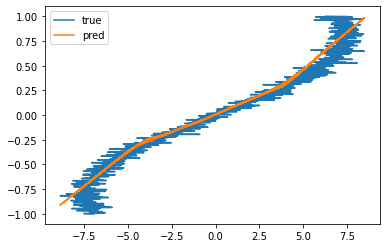

In [61]:
train_and_plot(period=2, n=1000, epochs=50)

## one-to-many mapping

Generating dataset ...
Training model ...
Making predictions ...


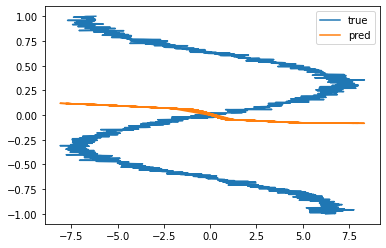

In [62]:
train_and_plot(period=5, n=1000, epochs=50)

**OBSERVATIONS:** When data is ambigious (x-y has one-to many mapping) the model struggles to make sensible predictions.

# Could my loss function help fix this model?

- It won't help in regression, but may help in classification.

- It won't help in regression, because, in case of one-to-many mapping in the dataset, regression model will output an average between those answers as this minimises the Squared Error. 

- In classification, however, model has to point to some answer -> max(softmax), thus it will have to choose to point to one or another output (can't average the two).

- thus my loss function could help in classification. 

- Also if we changed loss function from MSE to MAE maybe my loss could also help in regression, as in MSA for ambigious inputs (1 to 2 mapping) any answer that lies between two outputs (including on the spot of the output) will generate the same error. For 1 to 3 mapping, the network should choose the output in the middle to minimise MAE. 

**Next steps:**
* see what heppens when we use MSA instead of MSE in regression
* modify the dataset for y to belong to one of 100 categories (discretise it). and apply a softmax function over these 100 categories rather than a MSE



## using MAE instead of MSE

Generating dataset ...
Training SIMPLE model ...
Epoch 1/50
32/32 [==============================] - 0s 2ms/step - loss: 0.5804
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4787
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4692
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4695
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4677
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4669
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4689
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4655
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.4674
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4661
Epoch 11/50
32/32 [==============================] - 0s 1ms/step - loss: 0.4675
Epoch 12/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4663


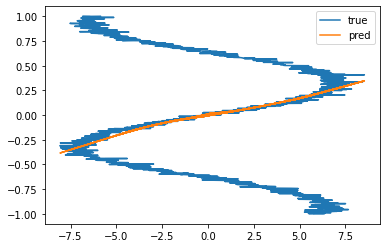

In [110]:
train_and_plot(period=5, n=1000, epochs=50, loss="mean_absolute_error", verbose=1)

**OBSERVATIONS:** Here we can see that there is 1-to-3 mapping (x-to-3 ys) for most x points. MSA is minimised by choosing the middle point. We could potentially use **my loss function** with two extra heads where we want to maximise KL divergence with the first head. **We Hypothesise** that objectives of mnimising MAE and maximising KL-divergence with first head will result in network picking up the two alternative solutions with the two extra heads.

In [182]:
def multiple_heads_model(num_heads):
    input_ = layers.Input(shape=(1))
    x = layers.Dense(100, activation='relu')(input_)
    x = layers.Dense(100, activation='relu')(x)
    heads = []
    for i in range(num_heads):
        if i == 0:
            head = x
        else:
            head = tf.stop_gradient(x)
        head = layers.Dense(50, activation='relu')(head)    
        head = layers.Dense(50, activation='relu')(head)
        y = layers.Dense(1)(head)
        heads.append(y)

    y = layers.Concatenate()(heads)
    model = Model(inputs = input_, outputs = y)
    return model

In [190]:
def MAE_with_extra_heads(weights={'mae':1, 'kl': 1}, num_heads=3):
    weights_total = weights['mae'] + weights['kl']
    mae_weight = weights['mae'] / weights_total
    kl_weight = weights['kl'] / weights_total
    
    def custom_loss(y_true, y_pred):
        
        # MAE
        mae_loss_total = 0
        for i in range(num_heads):
            mae_loss = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred[:,i])
            mae_loss_total += mae_loss
            
        # KL-div losses
        kl_div_loss_total = 0
        for i in range(num_heads):
            for j in range(i):
                kl_div_loss = tf.keras.losses.KLDivergence()(tf.stop_gradient(y_pred[:,j]), y_pred[:,i])
#                 kl_div_loss = tf.keras.losses.MeanAbsoluteError()(tf.stop_gradient(y_pred[:,j]), y_pred[:,i])
                if i != 2:
                    kl_div_loss_total += kl_div_loss
                    
                else:
                    kl_div_loss_total += 0.5 * kl_div_loss
                    
        loss_total = mae_weight * mae_loss_total - kl_weight * kl_div_loss_total

        return loss_total
    
    return custom_loss

Generating dataset ...
Training MANY HEADS model ...
Epoch 1/40
32/32 [==============================] - 0s 3ms/step - loss: -4.1096
Epoch 2/40
32/32 [==============================] - 0s 3ms/step - loss: -1.7476
Epoch 3/40
32/32 [==============================] - 0s 5ms/step - loss: -2.6030
Epoch 4/40
32/32 [==============================] - 0s 5ms/step - loss: -3.2609
Epoch 5/40
32/32 [==============================] - 0s 4ms/step - loss: -3.3460
Epoch 6/40
32/32 [==============================] - 0s 5ms/step - loss: -3.0853
Epoch 7/40
32/32 [==============================] - 0s 5ms/step - loss: -2.9659
Epoch 8/40
32/32 [==============================] - 0s 4ms/step - loss: -3.1024
Epoch 9/40
32/32 [==============================] - 0s 4ms/step - loss: -3.2673
Epoch 10/40
32/32 [==============================] - 0s 3ms/step - loss: -2.7855
Epoch 11/40
32/32 [==============================] - 0s 6ms/step - loss: -2.8263
Epoch 12/40
32/32 [==============================] - 0s 6ms/step 

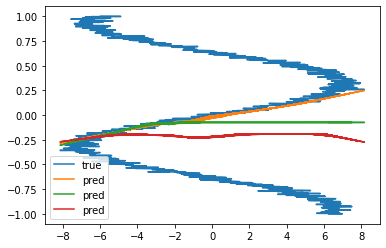

In [196]:
num_heads = 3
custom_loss = MAE_with_extra_heads(weights={'mae': 1, 'kl': 0.1}, num_heads=num_heads)

train_and_plot(period=5, n=1000, epochs=40, loss=custom_loss, num_heads=num_heads, verbose=1)

**KL divergence doesn't seem like right measure of distance between non-distributions.** We can observe that the optimisation only separates the positive part of x-axis. I'm not sure whether it makes sense to compute KL-div for negative numbers, probably doesn't as in KL you have a log term...

**Alternative distance measure:** We could use some alternative distance measure between each output head. However it has to be somehow connected to the original MAE with the ground truth. As otherwise the objective to maximise MAE(y_1,y_2) will shoot to infinity.

**How do you stop the distance metric from exploading?** Obviously if you try to maximise separation between two numbers they will just indeterminately keep moving away from each other. It would have to be something like: **"keep moving away from 1st output head until you find a location along y where the gardient of loss increases, stop there"**.

MAE loss function for this problem is fully convex (see sketch in my notes). two alternative solutions could be found only if we were able to identify where does the gradient increases.

### just because this MAE problem is properlly convex - we can't find two alternative solutions with my method (where we somehow maximise distance between output heads). 

### If the primary loss function had multiple local minima, maybe it would be possible to find this sub-optimal neighbouring local minima - but for that, after entering the convex region of that sub-optima the gradient of primary loss function would have to be greater than that of loss responsible for ditance between output heads.

# ad-hoc MDN

We know that there are 3 y outputs for each x. Let's make the model to predict all 3 y's ! While the dataset only has pairs.

In [ ]:
def predict_3_Ys_model():
    input_ = layers.Input(shape=(1))
    x = layers.Dense(100, activation='relu')(input_)
    x = layers.Dense(100, activation='relu')(x)
    heads = []
    for i in range(num_heads):
        if i == 0:
            head = x
        else:
            head = tf.stop_gradient(x)
        head = layers.Dense(50, activation='relu')(head)    
        head = layers.Dense(50, activation='relu')(head)
        y = layers.Dense(1)(head)
        heads.append(y)

    y = layers.Concatenate()(heads)
    model = Model(inputs = input_, outputs = y)
    return model

# Mixture Density Network (MDN)

**Implement MDN such that it can identify 3 modes of mapping from x to y**

# Create generative model (... work in progress)

**Use generative model to identify 3 modes of mapping from x to y**

\begin{align}
p(i,c,t,\epsilon) & = p(i|c,\epsilon)p(c|t)p(\epsilon; \sigma)p(t) \\
p(t|i) & = \frac{\sum^C\sum^{\epsilon}{p(i,c,t,\epsilon)}}{\sum^T\sum^C\sum^{\epsilon}{p(i,c,t,\epsilon)}}
\end{align}

$p(t)=Uniform(-100,100)$ - prior, fully defined

$p(\epsilon; \sigma) = N(0,\epsilon) = N(0, 0.05)$ - prior, fully defined

$p(c|t)$

$p(i|c, \epsilon) = N(i; \mu(c), \sigma) = N(i; \mu(c), 0.05)$ - gaussian distirbution. Model parameters are $\mu(.)$ for each cluster *c*.